In [98]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
# cnn model
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot as plt

import copy
from tqdm import tqdm
from typing import Tuple

import torch.nn as nn
import torch
import numpy as np

import sys
from scipy import signal
from scipy.io import wavfile

import glob
from skimage import util
import pydub
import os
import cv2

In [142]:
sys.path.append('../utils')

# importing
from emg_data_loading import *

In [143]:
person ='Amanda'
emg_path ='../../../data/data_pre_processed/'
survey_file = '../../../data/survey_data/pre_processed_survey_features.csv'
survey = pd.read_csv(survey_file)
identifiers  = pd.concat([get_dates('Amanda', survey, emg_path, 'hooper_muscles_sore')])

In [145]:
data = data_loader(identifiers,survey,emg_path)

In [147]:

#data = data[(data['muscle_contraction_1']==1)|(data['muscle_contraction_2']==1)|(data['muscle_contraction_3']==1)]
data = data[(data['sit_relaxed_1']==1)|(data['sit_relaxed_2']==1)]

#data = data[data['wallsit']==1]
for num, ids in identifiers.iterrows():
    date = ids['date']
    person = ids['person']
    timing = ids['timing']
    signal = data.loc[(data['date']==date)&(data['person']==person)&(data['timing']==timing),'signal_emg']
    # Lens Size
    M = 250
    try:
        # cut into slices for calculating FFT
        slices = util.view_as_windows(np.array(signal), window_shape =(M,), step=int(M/4))

        # create a window function
        win = np.hanning(M+1)[:-1]
        slices = slices * win

        # take transpose to have one slice per column
        slices = slices.T
        # print('Shape of Slices:', slices.shape)

        # for each slice calculate DFT and slice out positive values
        spectrum = np.fft.fft(slices, axis = 0)[:M // 2]
        spectrum = np.abs(spectrum)

        # Calculate length of spectrum and number of samples of length 256 in this spectrum
        N = spectrum.shape[1]
        K = round((N/(M/4))-0.5)

        for k in range(1,K-1):

            # slice out pieces of size 256 of the spectrum
            spectrum_slice = spectrum[:,(k-1)*int(M/4):(k+1)*int(M/4)]

            # plot spectrogram
            fig = plt.figure() # create plot
            S = np.abs(spectrum_slice) # take absolute values
            S = 20 * np.log10(S / np.max(S)) # adjust data scale
            sizes = np.shape(S)  # get shape of data
            fig.set_size_inches(1. * sizes[0] / sizes[1], 1, forward=False) # set figure size
            ax = plt.Axes(fig, [0., 0., 1., 1.]) # set axis size so we don't have a border
            ax.set_axis_off()
            fig.add_axes(ax)
            ax.imshow(S, cmap='jet')  # plot in kHz, log of spectrogram, decide on colouring


            # specify name of plot
            name=date+'_'+person+'_'+timing

            # save figure without border to folder for respective emotion, named after the original wav File
            save_results_to = '/Users/htr365/no_icloud/quantified_self_all/data/spectrograms/AB_sit_relaxed/'
            plt.savefig(save_results_to + name +'_'+ str(k) + '.png', dpi = sizes[0])
            plt.close()
    except:
        next

In [148]:
outcome = 'cis_subjective_fatigue'

In [149]:
# Create placeholders for image data list and label list
img_data_list = []
labels_list = []
date_list = []

#  Get data path to folder that contains a folder for each label with corresponding spectrograms
data_path = '/Users/htr365/no_icloud/quantified_self_all/data/spectrograms/AB_sit_relaxed'

# read in data
img_list = [f for f in os.listdir(data_path) if f.endswith('.png')]
for img in img_list:
    print(img)
    #try:     
    date = img.split('_')[0]
    person = img.split('_')[1]
    label = survey[(survey['person'] == person)*(survey['date']==(pd.to_datetime(date)+timedelta(1)).strftime("%Y-%m-%d"))][outcome]
    if len(label)==1:
        labels_list.append(label.values[0])
        date = img.split('_')[0]
        person = img.split('_')[1]
        timing =  img.split('_')[2]
        input_img=cv2.imread(data_path + '/' + img)
        input_img_resize = cv2.resize(input_img, (128, 128))
        img_data_list.append(input_img_resize)


        date_list.append(date)
    #except:
     #  next

# convert to numpy array and then to float, normalize through dividing by 511
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data /= 511 # divide by 511
img_data = img_data.transpose(0,3,1,2)
print(img_data.shape)

2024-07-27_Amanda_AM_5.png
2024-06-25_Amanda_AM_3.png
2024-07-16_Amanda_PM_16.png
2024-07-20_Amanda_AM_1.png
2024-07-19_Amanda_PM_11.png
2024-07-27_Amanda_PM_11.png
2024-08-13_Amanda_AM_20.png
2024-07-09_Amanda_PM_17.png
2024-07-09_Amanda_PM_7.png
2024-08-03_Amanda_PM_12.png
2024-07-17_Amanda_PM_2.png
2024-07-09_Amanda_AM_23.png
2024-08-13_Amanda_PM_14.png
2024-07-27_Amanda_AM_25.png
2024-07-16_Amanda_AM_22.png
2024-07-10_Amanda_PM_6.png
2024-07-19_Amanda_AM_19.png
2024-08-13_Amanda_PM_28.png
2024-07-27_Amanda_AM_19.png
2024-07-24_Amanda_AM_13.png
2024-08-10_Amanda_AM_1.png
2024-07-15_Amanda_AM_28.png
2024-07-27_Amanda_PM_8.png
2024-07-15_Amanda_AM_14.png
2024-08-04_Amanda_PM_7.png
2024-08-03_Amanda_PM_3.png
2024-07-24_Amanda_PM_27.png
2024-07-22_Amanda_PM_4.png
2024-07-12_Amanda_PM_12.png
2024-08-08_Amanda_AM_25.png
2024-08-12_Amanda_AM_9.png
2024-08-08_Amanda_AM_19.png
2024-07-28_Amanda_AM_7.png
2024-07-23_Amanda_PM_15.png
2024-07-23_Amanda_AM_21.png
2024-07-12_Amanda_AM_3.png
2024-0

In [150]:
indicators_train, indicators_val, indicators_test = identifiers[pd.to_datetime(identifiers['date'])<pd.to_datetime('2024-08-03')],\
    identifiers[(pd.to_datetime(identifiers['date'])<pd.to_datetime('2024-08-07'))*(pd.to_datetime(identifiers['date'])>=pd.to_datetime('2024-08-03'))],\
    identifiers[pd.to_datetime(identifiers['date'])>=pd.to_datetime('2024-08-07')]

In [151]:
targets = torch.from_numpy(np.array(labels_list,dtype=np.float32)[np.where(np.isin(date_list, indicators_train['date']))[0]])
targets

tensor([4.8750, 4.7500, 6.0000,  ..., 5.2500, 6.3750, 4.8750])

In [152]:

class CNNRegression(nn.Module):
    """
    This will be the very basic CNN model we will use for the regression task.
    """
    def __init__(self, image_size: Tuple[int, int, int] = (3, 100, 100)):
        super(CNNRegression, self).__init__()
        self.image_size = image_size
        self.conv1 = nn.Conv2d(in_channels=self.image_size[0], out_channels=4, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_line_size = int(16*(image_size[1]//4)*(image_size[2]//4))
        self.fc1 = nn.Linear(in_features=self.linear_line_size, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=1)

        
    def forward(self, x):
        """
        Passes the data through the network.
        There are commented out print statements that can be used to 
        check the size of the tensor at each layer. These are very useful when
        the image size changes and you want to check that the network layers are 
        still the correct shape.
        """
        x = self.conv1(x)
        # print('Size of tensor after each layer')
        # print(f'conv1 {x.size()}')
        x = nn.functional.relu(x)
        # print(f'relu1 {x.size()}')
        x = self.pool1(x)
        # print(f'pool1 {x.size()}')
        x = self.conv2(x)
        # print(f'conv2 {x.size()}')
        x = nn.functional.relu(x)
        # print(f'relu2 {x.size()}')
        x = self.pool2(x)
        #print(f'pool2 {x.size()}')
        x = x.reshape(-1, self.linear_line_size)
        #print(f'view1 {x.size()}')
        x = self.fc1(x)
        # print(f'fc1 {x.size()}')
        x = nn.functional.relu(x)
        # print(f'relu2 {x.size()}')
        x = self.fc2(x)
        #print(x)

        # print(f'fc2 {x.size()}')
        return x
    

In [153]:
image_size=tuple(img_data.shape[1:])

model = CNNRegression(image_size=image_size)


In [134]:
img_data.shape[0]

4035

In [135]:
torch.from_numpy(img_data[np.where(np.isin(date_list, indicators_train['date']))]).shape

torch.Size([3147, 3, 128, 128])

0
Epoch [1/1000], Loss: 4.7535
Epoch [1/1000], Loss: 2.7199
Epoch [1/1000], Loss: 1.3199
Epoch [1/1000], Loss: 2.0855
Epoch [1/1000], Loss: 2.4974
Epoch [1/1000], Loss: 1.8879
Epoch [1/1000], Loss: 1.4670
Epoch [1/1000], Loss: 1.1691
Epoch [1/1000], Loss: 1.2593
Epoch [1/1000], Loss: 1.3104
Epoch [1/1000], Loss: 1.3610
tensor(2.2167, grad_fn=<MeanBackward0>)
1
Epoch [2/1000], Loss: 1.1547
Epoch [2/1000], Loss: 1.0533
Epoch [2/1000], Loss: 1.1583
Epoch [2/1000], Loss: 1.1033
Epoch [2/1000], Loss: 1.2379
Epoch [2/1000], Loss: 1.0840
Epoch [2/1000], Loss: 1.2870
Epoch [2/1000], Loss: 1.0376
Epoch [2/1000], Loss: 0.9231
Epoch [2/1000], Loss: 0.9754
Epoch [2/1000], Loss: 0.9467
tensor(2.6274, grad_fn=<MeanBackward0>)
2
Epoch [3/1000], Loss: 1.0448
Epoch [3/1000], Loss: 1.0371
Epoch [3/1000], Loss: 1.1091
Epoch [3/1000], Loss: 0.9350
Epoch [3/1000], Loss: 1.1223
Epoch [3/1000], Loss: 1.0501
Epoch [3/1000], Loss: 1.2614
Epoch [3/1000], Loss: 0.9828
Epoch [3/1000], Loss: 0.8341
Epoch [3/1000],

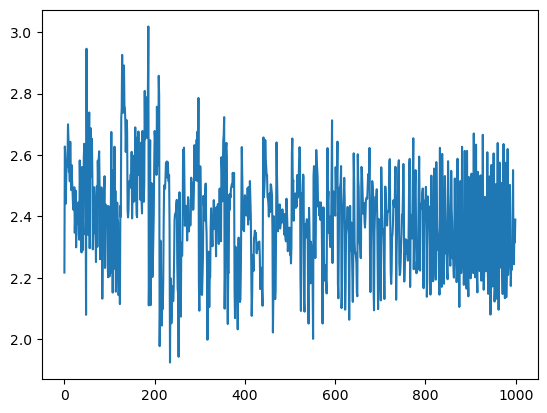

In [154]:

# Define the model, loss function, and optimizer
#model.to(device)
n_epochs=1000
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
batch_size= 100

train_shape = img_data[np.where(np.isin(date_list, indicators_train['date']))].shape[0]
batch_start = torch.arange(0, train_shape, batch_size)


# Hold the best model
best_mae= np.inf   # init to infinity
best_weights = None
history = []

# Train the model
#writer = SummaryWriter()
for epoch in range(n_epochs):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            print(epoch)
            for start in bar:
                #print(start)
            #for i, (inputs, targets) in enumerate(regression_task.trainloader):
                inputs = torch.from_numpy(img_data[np.where(np.isin(date_list, indicators_train['date']))])[start:start+batch_size]
                targets = torch.from_numpy(np.array(labels_list,dtype=np.float32)[np.where(np.isin(date_list, indicators_train['date']))[0]]).reshape(-1,1)[start:start+batch_size]
                #print(inputs.shape)
                #print(targets.shape)
                # Zero the gradients
                optimizer.zero_grad()

                # Forward pass
                #outputs = model(inputs.to(device))
                outputs = model(inputs)
                #print(outputs)
                loss = criterion(outputs, targets)

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                #writer.add_scalar('Train Loss', loss.item(), i)

                # Print training statistics
                #if (i + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4f}')
# evaluate accuracy at end of each epoch
    model.eval()
    #X_val, y_val = X_val.to(device), y_val.to(device)
    #print('val')
    #print(X_val.shape)
    X_val = torch.from_numpy(img_data[np.where(np.isin(date_list, indicators_val['date']))])
    y_val = torch.from_numpy(np.array(labels_list,dtype=np.float32)[np.where(np.isin(date_list, indicators_val['date']))[0]]).reshape(-1,1)

    y_pred = model(X_val)

    mae = criterion(y_pred, y_val)
    print(mae)
    mae = float(mae)
    history.append(mae)
    if mae < best_mae:
        best_mae = mae
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MAE: %.2f" % best_mae)
#print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()


In [155]:
inputs_test = torch.from_numpy(img_data[np.where(np.isin(date_list, indicators_test['date']))])
outputs_test =  torch.from_numpy(np.array(labels_list,dtype=np.float32)[np.where(np.isin(date_list, indicators_test['date']))[0]]).reshape(-1,1)
y_pred = model(inputs_test)


In [156]:
dates_test = np.array(date_list)[np.where(np.isin(date_list, indicators_test['date']))[0]]


In [64]:
pd.Series(dates_test).shape

(666,)

In [65]:
pd.Series(outputs_test.reshape(-1)).shape

(3147,)

In [157]:
out = pd.concat([pd.Series(dates_test),pd.Series(outputs_test.reshape(-1)),pd.Series(y_pred.detach().numpy().reshape(-1))],axis=1).\
rename(columns={0:'date',1:'true',2:'pred'})
out_daily = out.groupby('date').mean()

In [158]:
np.mean(np.abs(out_daily['pred'] - out_daily['true']))

1.924612

In [141]:
out_daily

,true,pred
date,,
2024-08-07,2.125,5.490951
2024-08-08,5.875,4.910165
2024-08-09,5.375,5.573785
2024-08-10,6.500,4.839980
2024-08-12,5.750,5.293156
2024-08-13,5.250,4.801107


In [124]:
outcome

'cis_subjective_fatigue'

In [159]:
out.to_csv('/Users/htr365/no_icloud/quantified_self_all/quantified_self/data_processing/ml_pipeline/prediction/amanda_spec_fatigue_predictions_relaxed.csv')
out_daily.to_csv('/Users/htr365/no_icloud/quantified_self_all/quantified_self/data_processing/ml_pipeline/prediction/amanda_spec_daily_fatigue_prediction_relaxed.csv')